In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [135]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask].cases
    test_mask = (data.index > "2011")
    test = data[test_mask].cases
    return train, test

In [136]:
provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)

cr_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangRai'].resample('W').size()
cr_dengues_df = pd.DataFrame(cr_dengues,columns=['cases'])
cr_train_test = split_data(cr_dengues_df)
cr_dengues_train, cr_dengues_test = cr_train_test[0], cr_train_test[1]

cm_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangMai'].resample('W').size()
cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])
cm_train_test = split_data(cm_dengues_df)
cm_dengues_train, cm_dengues_test = cm_train_test[0], cm_train_test[1]

all_dengues = provinces_df.resample('W').size()
all_dengues_df = pd.DataFrame(all_dengues,columns=['cases'])
all_train_test = split_data(all_dengues_df)
all_dengues_train, all_dengues_test = all_train_test[0], all_train_test[1]

In [4]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot([i for i in range(len(real))],np.array(real),'-r',label=real_legend)
    plt.plot([i for i in range(start_week,len(real)+1)],predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)

$$\sigma\,(w_{i}\cdot x_{i}) = \sum_{i=0}^{n} w_{i} x_{i}$$

$$Seasonal\,Part_{0} =\,\sin(\dfrac{\pi}{52}\,(x_{\,week\,to\,predict} - c)) + k$$

$$cases = (\sigma(w\cdot x) \,\times Seasonal\,Part) +\, k$$

## predict n weeks ahead by using the new set of betas
 
0-25: 29, 1-26: 30, 2-27: 31, 3-28:32, 4-29:33, 5-30:34

if the length of data is N, length of prediction would be N - (lag + week ahead)

ex. test case has length of 20, week ahead is 2, and lag is 4, the length of prediction would be 14

$$g(\bar{x}) = \bar{x}_{n+4}$$

$$x_{n+4} = g(x_{n},\,x_{n-1},\,x_{n-2},\,x_{n-3},\,....\,x_{n-LAG})$$

In [129]:
def guess(w,x_week,y_case):
    
    def sigma(w,y_case):
        pad_y = np.concatenate(([1],np.array(y_case)))
        all_cases = np.dot(w[:-3],pad_y)
        return all_cases

    def season_cos_sq(w,x_week):
        pi = np.math.pi
        coeff = pi/52.
        inside = (coeff*x_week) - (coeff*w[-2])
        cosine_sq = np.math.cos(inside)**2
        score = cosine_sq + w[-3]
        return score    
    
    return (sigma(w,y_case) * season_cos_sq(w,x_week)) + w[-1]

def get_alphas(LAG,train,constant,n_week_ahead):
    n_week = n_week_ahead - 1
    W_CASE = LAG + 1
    W_POP = 1
    W_SEASON = 2
    BETAS_SET = W_POP + W_CASE + W_SEASON # addition of ALL_WS betas

    # use poison instead of least square
    def cost(w):
        ret = 0
        for week_no in range(len(train)-(LAG+n_week)): # 4 weeks ahead of current week. LAG+(week ahead - 1)
            week_nth = week_no+LAG+n_week # future week starting 0th week. (week ahead - 1)
#             print 'week_no', week_no
#             print "week_nth", week_nth # 29
#             print 'in train',train[week_no:week_no+LAG][0],train[week_no:week_no+LAG][-1] # train[0:29][-1] == train[28]
            real_case = train[week_nth] # 4 weeks ahead of current week. LAG+(week ahead - 1)
#             print 'real',train[week_nth] # train[29]
            predicted_case = guess(w,week_nth,train[week_no:week_no+LAG]) #guess(26ws,week 29th,train[:26])
#             print 'pred',predicted_case
            sigma_sq = real_case + 1 # assume poisson and avoid division by zero
            ret += ((real_case - predicted_case)**2)/float(sigma_sq)
#         print ret
        return ret

    seasonality_starters = [0.75,20] # [amplitude,constant,period,phase]
    arr = np.array([0.]*W_CASE) #  betas
#     arr = np.array(pd.read_csv('starter_ws.csv')['starter_ws'][:-1])
    arr = np.append(arr,seasonality_starters) # 29 betas
    arr = np.append(arr,constant) # 30 betas
    w = minimize(cost,arr)
    return w

#get_alphas(26,cm_dengues_train,-9.26e-01,4)

In [109]:
# print cm_dengues_train[0:26][-1]
# print cm_dengues_train[25]
# print cm_dengues_train[:34]
print cm_dengues_train[:30]
print cm_dengues_train[29]

date
2003-01-05      1
2003-01-12      2
2003-01-19      5
2003-01-26      0
2003-02-02      2
2003-02-09      2
2003-02-16      1
2003-02-23      4
2003-03-02      3
2003-03-09      3
2003-03-16      2
2003-03-23      3
2003-03-30      3
2003-04-06      2
2003-04-13      3
2003-04-20      6
2003-04-27     10
2003-05-04     10
2003-05-11     18
2003-05-18     31
2003-05-25     25
2003-06-01     49
2003-06-08     76
2003-06-15     91
2003-06-22    101
2003-06-29    100
2003-07-06     97
2003-07-13     89
2003-07-20     95
2003-07-27    124
Freq: W-SUN, Name: cases, dtype: int64
124


### def get_alphas(LAG, train, constant, n_week_ahead)
function takes in LAG that want to be trained, data to train, starting point for constant, and amount of week you want to predict
- the function returns set of alphas

each plotting of the prediction for n-weeks ahead requires a different set of alphas. This function allows that by having 2 variables [LAG, week_ahead] for altering LAG and increase period of prediction.

In [130]:
cm_26_4weeks = get_alphas(26,cm_dengues_train,-9.26e-01,4) # 4 weeks ahead

In [84]:
cm_26_12weeks = get_alphas(26,cm_dengues_train,-9.26e-01,12)

In [146]:
cm_26_4weeks.x

array([  3.09780287e+00,  -1.02210467e-02,  -1.31193409e-02,
        -5.97403890e-03,   7.91526956e-02,  -7.76587238e-02,
        -1.40506020e-02,  -7.23011403e-05,  -7.39007164e-02,
         6.94758901e-02,   1.57311150e-02,   3.43871021e-02,
        -8.53204350e-02,   5.87134296e-02,   1.25875013e-01,
        -6.12263929e-02,   1.86051009e-01,  -8.25776917e-02,
        -9.40394005e-02,   4.74164275e-02,  -1.24833002e-01,
         2.98426533e-02,  -1.11764423e-01,  -1.35281747e-01,
         4.00617080e-02,   1.73027472e-01,   1.02598121e+00,
         2.67253844e-01,   2.23300936e+01,  -1.20648600e+00])

In [147]:
cm_26_12weeks.x

array([  3.26338640e+01,  -8.58203794e-02,  -2.07879614e-02,
         1.80640020e-02,  -6.43259369e-02,  -1.94484436e-02,
        -1.20153993e-02,   1.36803898e-01,  -8.48431968e-03,
         1.00364912e-01,  -7.51936466e-03,   1.16215656e-02,
         6.88650426e-02,   1.42508456e-02,   9.20206445e-02,
        -6.93448910e-02,  -4.13652827e-02,   3.35993086e-03,
         1.00872726e-01,   8.67742957e-02,  -3.41899360e-02,
        -3.90811826e-03,  -1.23004217e-01,  -1.28618974e-01,
         9.86734299e-02,  -1.17232236e-01,   3.00792471e-01,
         1.91935109e-01,   2.95470426e+01,  -1.11171144e+01])

In [ ]:
cm_dengues_test[-30:]

### def plot_specific_week_prediction(LAG,all_data,ws,n_week_ahead,province)
Function mainly takes in set of alphas and n_week_ahead that are different from other. Can only plot 1 graph per call.


In [162]:
def seperate_train_test(all_data,train_data):
    plt.axvspan(0, len(train_data), color='blue', alpha=0.1)
    plt.text((len(train_data)/2)-25,700,'Train Period',size=16)
    plt.axvline(len(train_data)+1,linewidth=0.5, color='green')
    plt.text(len(train_data)+150,700,'Test Period',size=16)
    plt.axvspan(len(train_data)+1, len(all_data), color='green', alpha=0.1)

                                  # 26, all_train_test, set of ws, 4, province
def plot_specific_week_prediction(LAG,all_data,ws,n_week_ahead,province):
    n_week = n_week_ahead - 1
    prediction = []
    train, test = all_data[0],all_data[1]
    train_test = np.append(train,test)
    for week_no in range(len(train_test)-(LAG-1)):
        nth_week = week_no+LAG+n_week
        res = guess(ws.x,nth_week,train_test[week_no:week_no+LAG])
        prediction.append(res)
    
    test_none = np.array(train_test)
    test_none = np.append(test_none,[None]*0)
    title = "%s's Dengue Prediction: %d week(s) ahead" %(province,n_week_ahead)
    make_line(26,test_none,prediction,title,"week # starting 2003","cases")
    seperate_train_test(train_test,train)
    

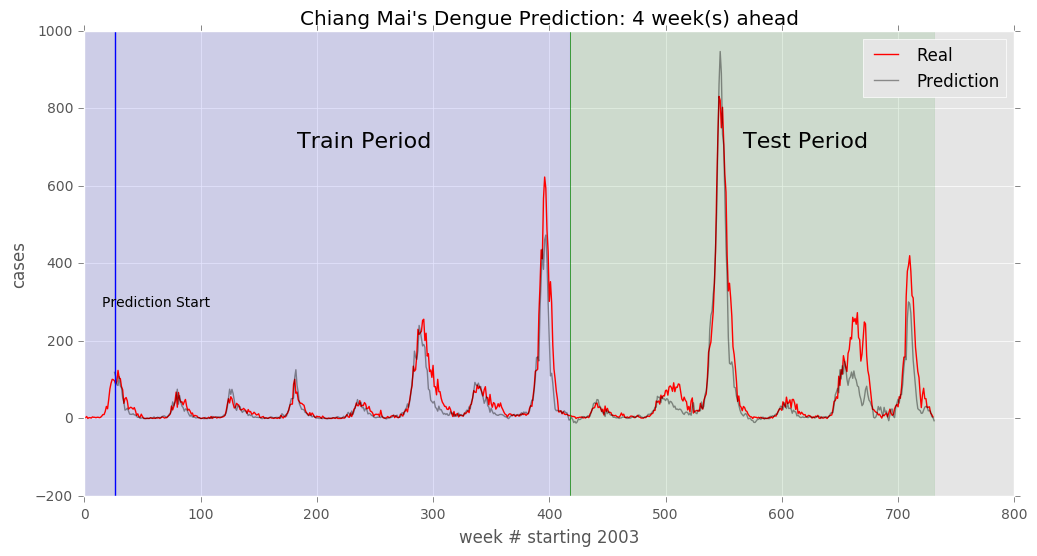

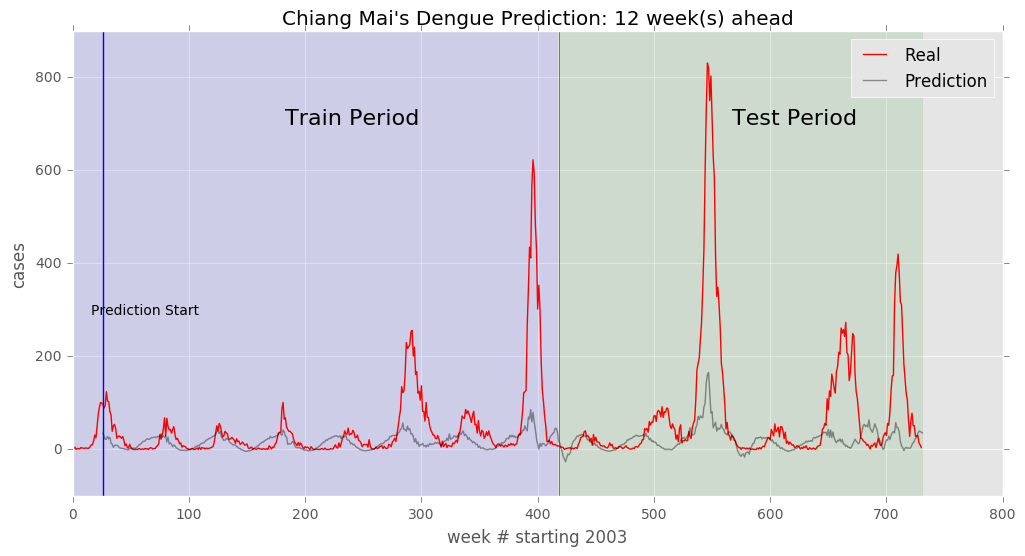

In [163]:
plot_specific_week_prediction(26,cm_train_test,cm_26_4weeks,4,"Chiang Mai")
plot_specific_week_prediction(26,cm_train_test,cm_26_12weeks,12,"Chiang Mai")

## Original prediction_maker and graph_drawer

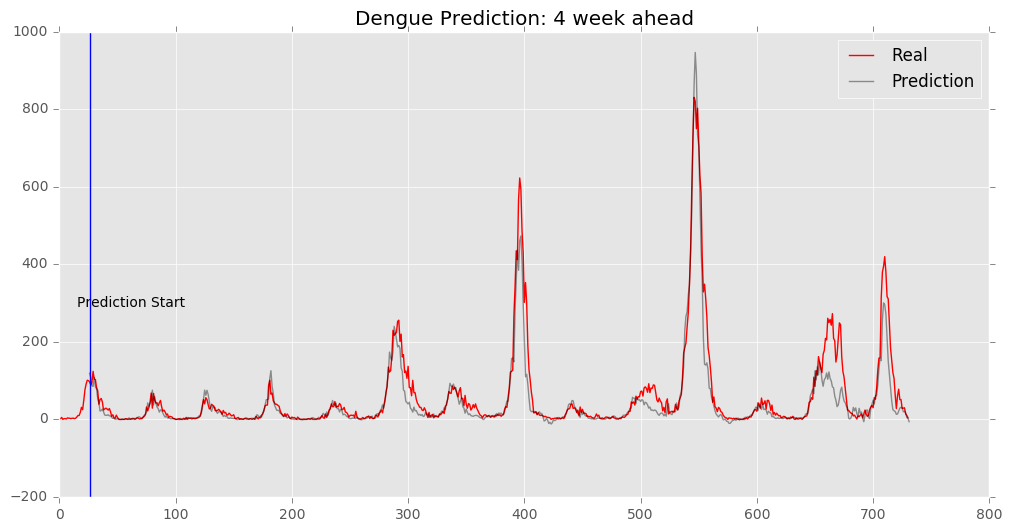

In [139]:
NWEEKS = 26
prediction_4week = []
# 2007 onward
train = cm_dengues_train
test = cm_dengues_test
train_test = np.append(train,test) #cm_dengues_df.cases
# print train_test
for i in range(len(train_test)-(NWEEKS-1)):
    nth_week = i+NWEEKS+3
#     print nth_week
#     print train_test[i:i+NWEEKS][0],train_test[i:i+NWEEKS][-1]
    res = 0
    res = guess(cm_26_4weeks.x,nth_week,train_test[i:i+NWEEKS])
    prediction_4week.append(res)
    
prediction_4week
    
test_none = np.array(train_test)
test_none = np.append(test_none,[None]*0)
make_line(26,train_test,prediction_4week,'Dengue Prediction: 4 week ahead',"","")
# plt.axvspan(0, len(train), color='blue', alpha=0.1)
# plt.text((len(train)/2)-25,900,'Train Period',size=16)
# plt.axvline(len(train)+1,linewidth=0.5, color='green')
# plt.text(len(train)+100,900,'Test Period',size=16)
# plt.axvspan(len(train)+1, len(train_test), color='green', alpha=0.1)
# # plt.axvline(416)
# # plt.axvline(420)

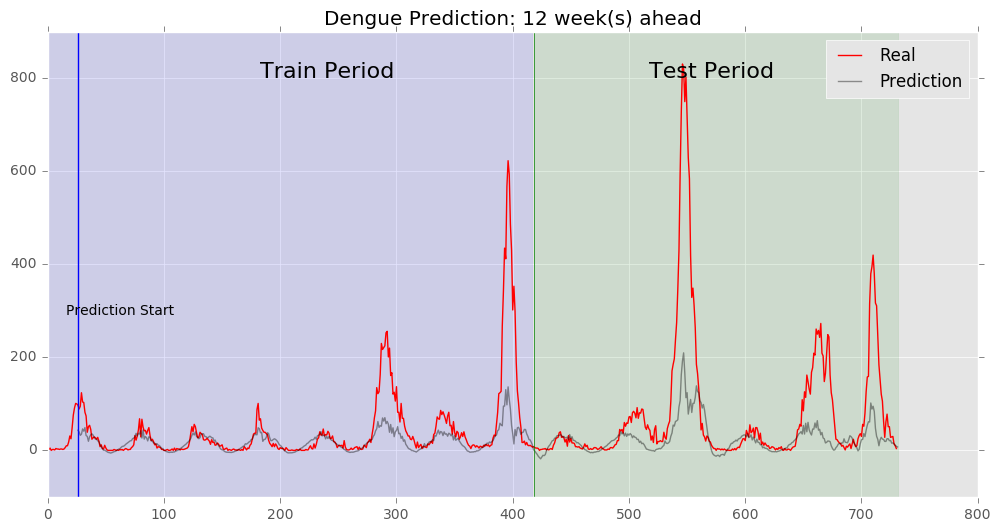

In [96]:
NWEEKS = 26
prediction_12week = []
# 2007 onward
train = cm_dengues_train
test = cm_dengues_test
train_test = cm_dengues_df.cases #cm_dengues_df.cases
# print train_test
for i in range(len(train_test)-(NWEEKS-1)):
    nth_week = i+NWEEKS+3
#     print week_to_predict+3
#     print train_test[i:i+NWEEKS][0],train_test[i:i+NWEEKS][-1]
    res = 0
    res = guess(cm_26_12weeks.x,nth_week,train_test[i:i+NWEEKS])
    prediction_12week.append(res)
    
# prediction_12week
    
test_none = np.array(train_test)
test_none = np.append(test_none,[None]*0)
make_line(26,test_none,prediction_12week,'Dengue Prediction: 12 week(s) ahead',"","")
plt.axvspan(0, len(train), color='blue', alpha=0.1)
plt.text((len(train)/2)-25,800,'Train Period',size=16)
plt.axvline(len(train)+1,linewidth=0.5, color='green')
plt.text(len(train)+100,800,'Test Period',size=16)
plt.axvspan(len(train)+1, len(train_test), color='green', alpha=0.1)

In [140]:
temp_cases = [i+1 for i in range(20)]
# n_week_ahead = 4
lag = 7
ct = 0
for week_no in range(len(temp_cases)-(lag-1)):
    print 'week_no',week_no+lag+3
    print temp_cases[week_no:week_no+lag]
    ct+=1
#     print 'real',temp_cases[week_no+lag+3]
ct

week_no 10
[1, 2, 3, 4, 5, 6, 7]
week_no 11
[2, 3, 4, 5, 6, 7, 8]
week_no 12
[3, 4, 5, 6, 7, 8, 9]
week_no 13
[4, 5, 6, 7, 8, 9, 10]
week_no 14
[5, 6, 7, 8, 9, 10, 11]
week_no 15
[6, 7, 8, 9, 10, 11, 12]
week_no 16
[7, 8, 9, 10, 11, 12, 13]
week_no 17
[8, 9, 10, 11, 12, 13, 14]
week_no 18
[9, 10, 11, 12, 13, 14, 15]
week_no 19
[10, 11, 12, 13, 14, 15, 16]
week_no 20
[11, 12, 13, 14, 15, 16, 17]
week_no 21
[12, 13, 14, 15, 16, 17, 18]
week_no 22
[13, 14, 15, 16, 17, 18, 19]
week_no 23
[14, 15, 16, 17, 18, 19, 20]


14